In [18]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import matplotlib_inline



In [19]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [20]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [21]:
print(f"Train Image Size: {train_images.shape}")
print(f"Train label Size: {train_labels.shape}")

print(f"Test Image Size: {test_images.shape}")
print(f"Test label Size: {test_labels.shape}")

Train Image Size: (60000, 28, 28)
Train label Size: (60000,)
Test Image Size: (10000, 28, 28)
Test label Size: (10000,)


### Data Exploration

In [22]:
print(f"Min value: {train_images[0].min()}\nMax Value: {train_images[0].max()}")

Min value: 0
Max Value: 255


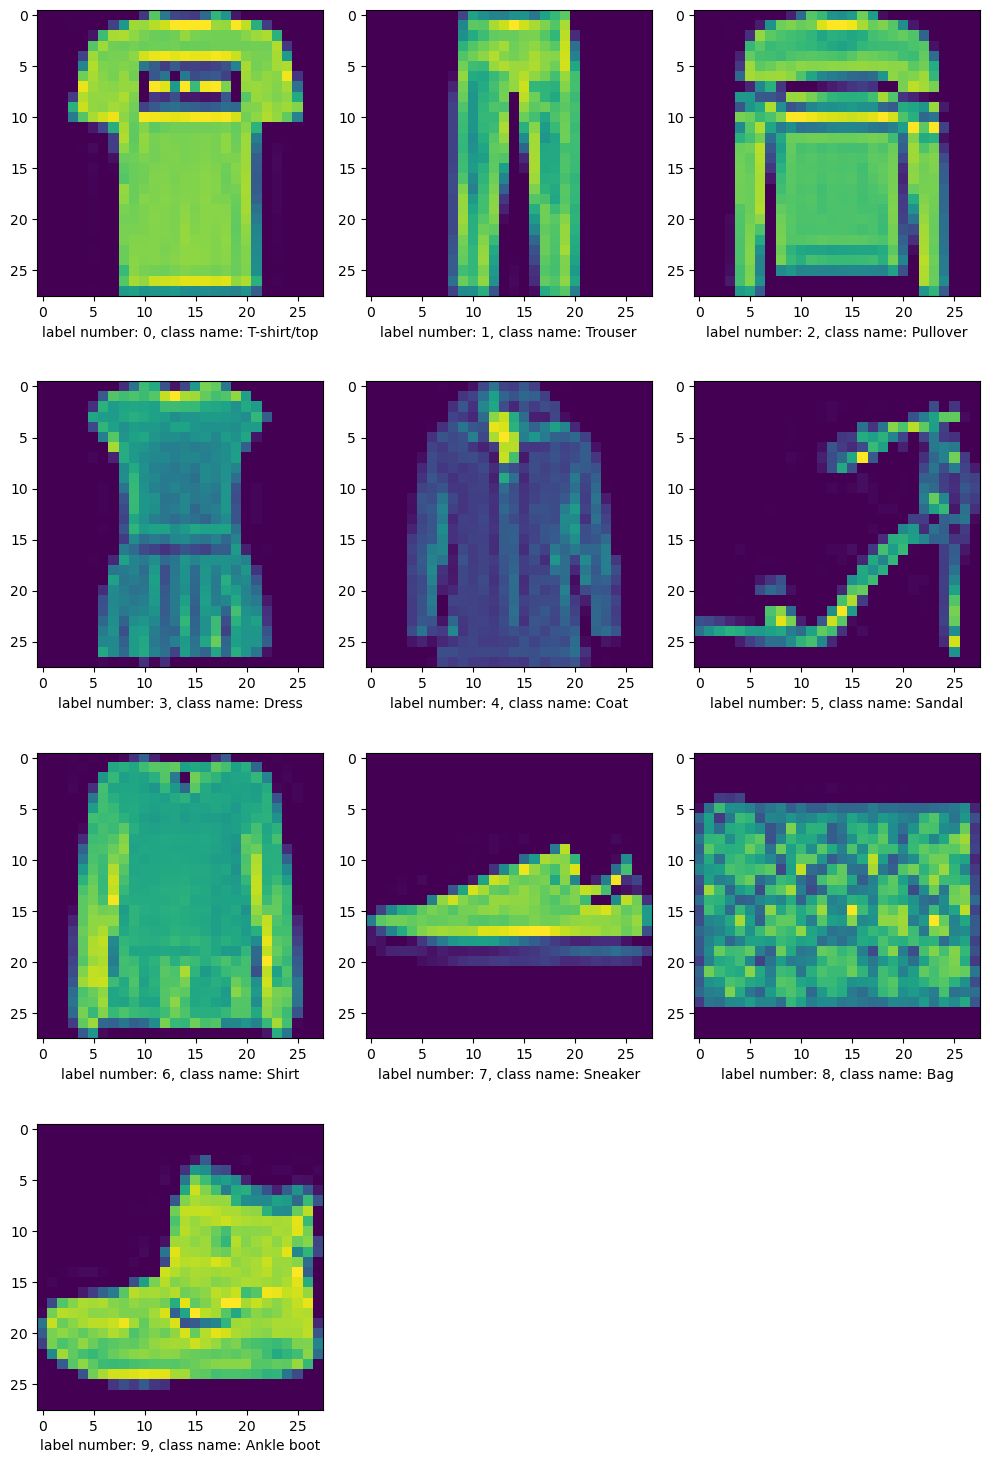

In [23]:
unique_values, indices = np.unique(train_labels, return_index=True)

fig, axs= plt.subplots(4, 3, figsize=(10, 15))
axs= axs.flatten()
for (unique_value, index) in (zip(unique_values, indices)):
    axs[unique_value].imshow(train_images[index])
    axs[unique_value].set_xlabel(f"label number: {unique_value}, class name: {class_names[unique_value]}")
    # print(f"{unique_value}, {class_names[unique_value]}: {index}")

# Leave the last two plots empty
for i in range(10, 12):  # Optional: Remove axes
    axs[i].axis('off')


plt.tight_layout()
plt.show()

In [24]:
#Normalization in the range of [0 - 1]
train_images = train_images / 255.0

test_images = test_images / 255.0

In [25]:
# One hot encoding, 
encoder = OneHotEncoder(sparse_output= False)

train_labels_onehot = encoder.fit_transform(train_labels.reshape(-1, 1))
test_labels_onehot = encoder.transform(test_labels.reshape(-1, 1))

In [26]:
print(train_labels.reshape(-1, 1).shape)
print(train_labels_onehot.shape)

(60000, 1)
(60000, 10)


In [27]:
gpu_devices = tf.config.list_physical_devices('GPU')

if not gpu_devices:
    print("TensorFlow is using the CPU.")
else:
    print(f"TensorFlow is using the following GPU(s): {gpu_devices}")

TensorFlow is using the following GPU(s): [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Model Development:

In [28]:
seed_value = 42
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

In [29]:
# Method to plot train and validation accuracy and loss over epoches.
def PlotTrainAndValidationAccuracyAndLoss(nn_model_history: tf.keras.callbacks.History, model_name: str):
    fig, axs = plt.subplots(1, 2, figsize=(25, 4))
    sns.lineplot(x=np.array(nn_model_history.epoch) + 1, y= nn_model_history.history['accuracy'], label='Train', ax = axs[0])
    sns.lineplot(x=np.array(nn_model_history.epoch) + 1, y= nn_model_history.history['val_accuracy'], label='Validation', ax = axs[0])
    axs[0].set_title(f'{model_name} accuracy')
    axs[0].set_ylabel('accuracy')
    # axs[0].set_xticks(range(1, len(nn_model_history.epoch) + 1))
    axs[0].set_xlabel('epoch')
    axs[0].legend(loc='upper left')

    sns.lineplot(x=np.array(nn_model_history.epoch) + 1, y= nn_model_history.history['loss'], label='Train', ax = axs[1])
    sns.lineplot(x=np.array(nn_model_history.epoch) + 1, y= nn_model_history.history['val_loss'], label='Validation', ax = axs[1])
    axs[1].set_title(f'{model_name} loss')
    axs[1].set_ylabel('loss')
    # axs[1].set_xticks(range(1, len(nn_model_history.epoch) + 1))
    axs[1].set_xlabel('epoch')
    axs[1].legend(loc='upper right')

    plt.tight_layout()
    plt.show()

### shallow neural network 1


In [30]:
#Shallow Neural Network Model 1
shallow_nn_model1 = tf.keras.Sequential([
    tf.keras.layers.Input(shape= (28, 28)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10)
])
shallow_nn_model1.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

shallow_nn1_history = shallow_nn_model1.fit(train_images, train_labels_onehot, epochs=100, validation_split= 0.2, batch_size= 32)

Epoch 1/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.7726 - loss: 0.6601 - val_accuracy: 0.8475 - val_loss: 0.4260
Epoch 2/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8594 - loss: 0.3971 - val_accuracy: 0.8560 - val_loss: 0.3953
Epoch 3/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8740 - loss: 0.3538 - val_accuracy: 0.8640 - val_loss: 0.3779
Epoch 4/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8832 - loss: 0.3244 - val_accuracy: 0.8673 - val_loss: 0.3705
Epoch 5/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8912 - loss: 0.3020 - val_accuracy: 0.8679 - val_loss: 0.3626
Epoch 6/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8958 - loss: 0.2855 - val_accuracy: 0.8735 - val_loss: 0.3525
Epoch 7/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9019 - loss: 0.2706 - val_accuracy: 0.8762 - val_loss: 0.3510
Epoch 8/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.9059 - loss: 

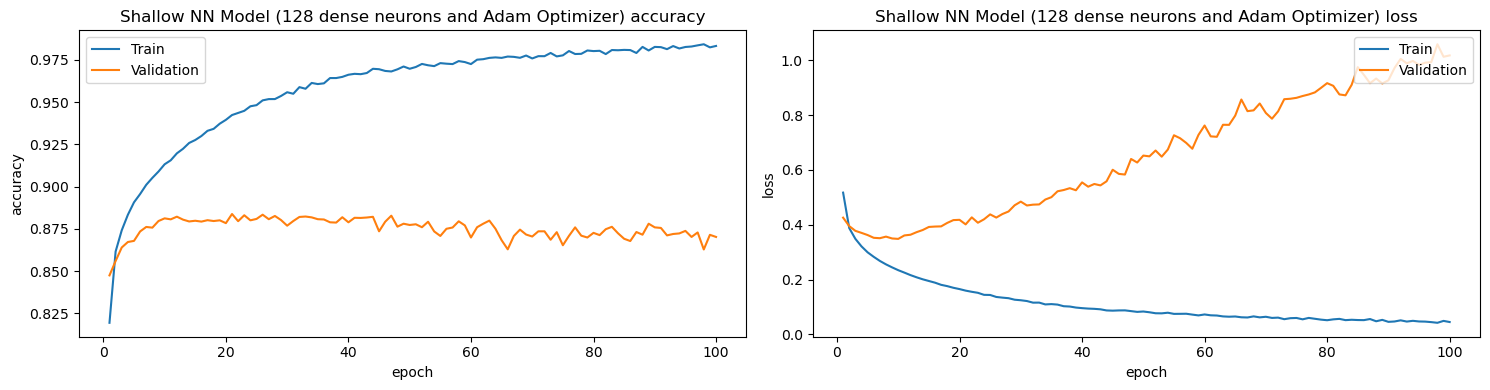

In [68]:
PlotTrainAndValidationAccuracyAndLoss(shallow_nn1_history, "Shallow NN Model (128 dense neurons and Adam Optimizer)")

313/313 - 1s - 3ms/step - accuracy: 0.8684 - loss: 1.0080

Test accuracy for shallow NN 1: 0.868399977684021

Test loss for shallow NN 1: 1.0080347061157227

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
first 10 predicted outputs: [9 2 1 1 6 1 4 6 5 7]

first 10 true outpurs: [9 2 1 1 6 1 4 6 5 7]

              precision    recall  f1-score   support

           0       0.87      0.72      0.79      1000
           1       0.99      0.97      0.98      1000
           2       0.77      0.81      0.79      1000
           3       0.90      0.87      0.88      1000
           4       0.82      0.74      0.77      1000
           5       0.96      0.95      0.95      1000
           6       0.60      0.76      0.67      1000
           7       0.94      0.95      0.94      1000
           8       0.97      0.97      0.97      1000
           9       0.95      0.96      0.95      1000

    accuracy                           0.87     10000
   macro avg       0.88      0.87      0.87     10000


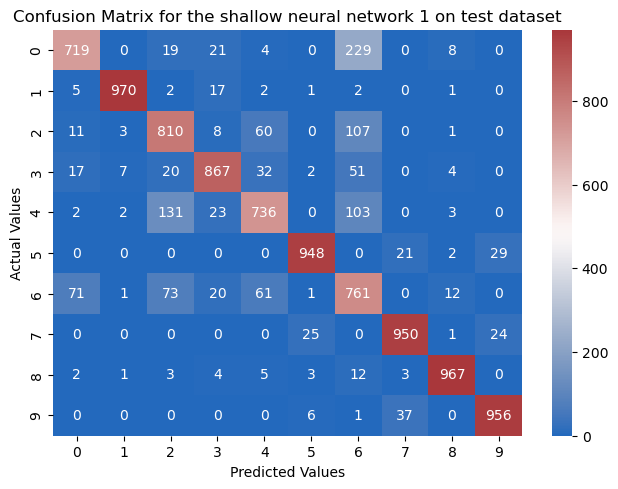

In [70]:
snn1_test_loss, snn1_test_acc = shallow_nn_model1.evaluate(test_images,  test_labels_onehot, verbose=2)

print(f'\nTest accuracy for shallow NN 1: {snn1_test_acc}\n')
print(f"Test loss for shallow NN 1: {snn1_test_loss}\n")

snn1_probability_model = tf.keras.Sequential([shallow_nn_model1, tf.keras.layers.Softmax()])
snn1_prediction_result_softmax= snn1_probability_model.predict(test_images,batch_size= 32)

snn1_test_label_pred = np.argmax(snn1_prediction_result_softmax, axis=1)  # Predicted labels

print(f"first 10 predicted outputs: {snn1_test_label_pred[:10]}\n")
print(f"first 10 true outpurs: {test_labels[:10]}\n")

# Print a classification report for shallow neural network classification model
snn1_classification_report = (classification_report(test_labels, snn1_test_label_pred))
print(snn1_classification_report)

# Print a confusion matrix for shallow neural network on test dataset

snn1_confusion_matrix= (confusion_matrix(test_labels, snn1_test_label_pred))

sns.heatmap(data= snn1_confusion_matrix,fmt='g', annot= True, cmap= "vlag")
plt.title("Confusion Matrix for the shallow neural network 1 on test dataset")
plt.tight_layout()
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.show()

### Shallow Neural Network Model 2

In [ ]:
#Shallow Neural Network Model 2
shallow_nn_model2 = tf.keras.Sequential([
    tf.keras.layers.Input(shape= (28, 28)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(10)
])
shallow_nn_model2.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

shallow_nn2_history = shallow_nn_model2.fit(train_images, train_labels_onehot, epochs=100, validation_split= 0.2, batch_size= 32)

Epoch 1/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.7808 - loss: 0.6244 - val_accuracy: 0.8534 - val_loss: 0.4117
Epoch 2/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8606 - loss: 0.3861 - val_accuracy: 0.8660 - val_loss: 0.3720
Epoch 3/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8777 - loss: 0.3405 - val_accuracy: 0.8724 - val_loss: 0.3550
Epoch 4/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8849 - loss: 0.3132 - val_accuracy: 0.8742 - val_loss: 0.3479
Epoch 5/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8930 - loss: 0.2916 - val_accuracy: 0.8792 - val_loss: 0.3370
Epoch 6/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8989 - loss: 0.2737 - val_accuracy: 0.8830 - val_loss: 0.3285
Epoch 7/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9038 - loss: 0.2587 - val_accuracy: 0.8773 - val_loss: 0.3440
Epoch 8/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9091 - loss: 0

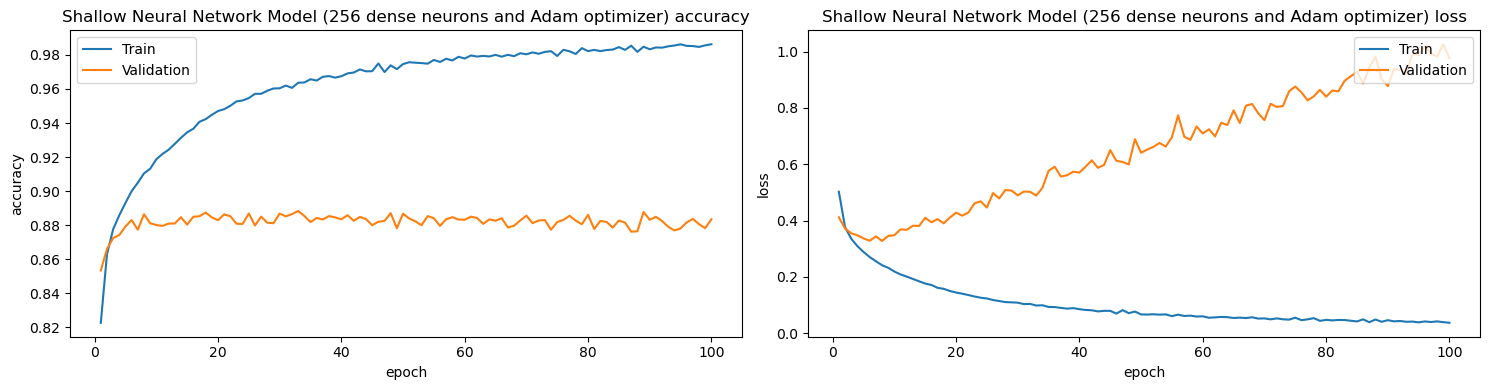

In [71]:
PlotTrainAndValidationAccuracyAndLoss(shallow_nn2_history, "Shallow Neural Network Model (256 dense neurons and Adam optimizer)")

313/313 - 2s - 6ms/step - accuracy: 0.8745 - loss: 1.0608

Test accuracy for shallow NN 2: 0.8744999766349792

Test loss for shallow NN 2: 1.0607848167419434

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
first 10 predicted outputs: [9 2 1 1 6 1 4 6 5 7]

first 10 true outpurs: [9 2 1 1 6 1 4 6 5 7]

              precision    recall  f1-score   support

           0       0.84      0.80      0.82      1000
           1       0.98      0.97      0.98      1000
           2       0.78      0.82      0.80      1000
           3       0.93      0.80      0.86      1000
           4       0.79      0.80      0.80      1000
           5       0.97      0.96      0.96      1000
           6       0.63      0.74      0.68      1000
           7       0.95      0.95      0.95      1000
           8       0.98      0.96      0.97      1000
           9       0.94      0.96      0.95      1000

    accuracy                           0.87     10000
   macro avg       0.88      0.87      0.88     10000

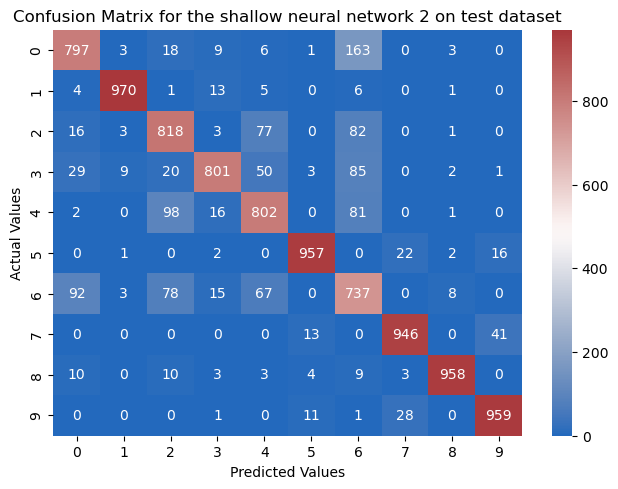

In [72]:
snn2_test_loss, snn2_test_acc = shallow_nn_model2.evaluate(test_images,  test_labels_onehot, verbose=2)

print(f'\nTest accuracy for shallow NN 2: {snn2_test_acc}\n')
print(f"Test loss for shallow NN 2: {snn2_test_loss}\n")

snn2_probability_model = tf.keras.Sequential([shallow_nn_model2, tf.keras.layers.Softmax()])
snn2_prediction_result_softmax= snn2_probability_model.predict(test_images,batch_size= 32)

snn2_test_label_pred = np.argmax(snn2_prediction_result_softmax, axis=1)  # Predicted labels

print(f"first 10 predicted outputs: {snn2_test_label_pred[:10]}\n")
print(f"first 10 true outpurs: {test_labels[:10]}\n")

# Print a classification report for shallow neural network classification model
snn2_classification_report = (classification_report(test_labels, snn2_test_label_pred))
print(snn2_classification_report)

# Print a confusion matrix for shallow neural network on test dataset

snn2_confusion_matrix= (confusion_matrix(test_labels, snn2_test_label_pred))

sns.heatmap(data= snn2_confusion_matrix,fmt='g', annot= True, cmap= "vlag")
plt.title("Confusion Matrix for the shallow neural network 2 on test dataset")
plt.tight_layout()
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.show()

In [ ]:
#Shallow Neural Network Model 3
shallow_nn_model3 = tf.keras.Sequential([
    tf.keras.layers.Input(shape= (28, 28)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(10)
])
shallow_nn_model3.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

shallow_nn3_history = shallow_nn_model3.fit(train_images, train_labels_onehot, epochs=100, validation_split= 0.2, batch_size= 32)

Epoch 1/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6833 - loss: 1.0134 - val_accuracy: 0.8147 - val_loss: 0.5623
Epoch 2/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8199 - loss: 0.5408 - val_accuracy: 0.8321 - val_loss: 0.4960
Epoch 3/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8364 - loss: 0.4818 - val_accuracy: 0.8397 - val_loss: 0.4654
Epoch 4/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8455 - loss: 0.4517 - val_accuracy: 0.8450 - val_loss: 0.4460
Epoch 5/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8526 - loss: 0.4314 - val_accuracy: 0.8493 - val_loss: 0.4315
Epoch 6/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8576 - loss: 0.4160 - val_accuracy: 0.8540 - val_loss: 0.4202
Epoch 7/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8616 - loss: 0.4035 - val_accuracy: 0.8561 - val_loss: 0.4109
Epoch 8/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8648 - loss: 0

Plot of accuracy and loss of the training set should be done before evaluation of model on test sets else store history in variable and reuse in future,

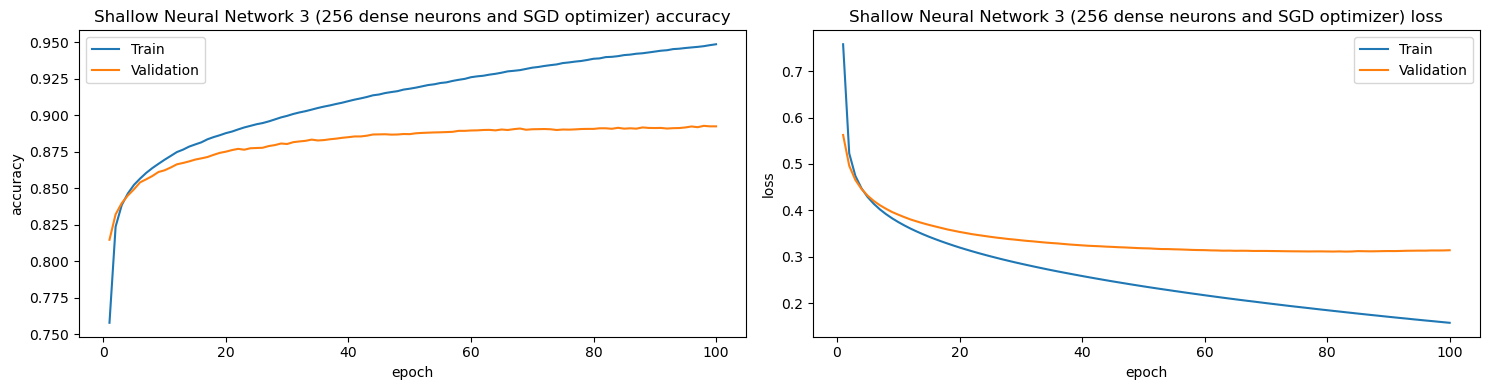

In [73]:
PlotTrainAndValidationAccuracyAndLoss(shallow_nn3_history, "Shallow Neural Network 3 (256 dense neurons and SGD optimizer)")

313/313 - 1s - 3ms/step - accuracy: 0.8844 - loss: 0.3448

Test accuracy for shallow NN 3: 0.8844000101089478

Test loss for shallow NN 3: 0.3447733223438263

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
first 10 predicted outputs: [9 2 1 1 6 1 4 6 5 7]

first 10 true outpurs: [9 2 1 1 6 1 4 6 5 7]

              precision    recall  f1-score   support

           0       0.87      0.80      0.83      1000
           1       0.99      0.97      0.98      1000
           2       0.77      0.83      0.80      1000
           3       0.89      0.88      0.88      1000
           4       0.81      0.81      0.81      1000
           5       0.96      0.96      0.96      1000
           6       0.71      0.73      0.72      1000
           7       0.93      0.96      0.94      1000
           8       0.96      0.96      0.96      1000
           9       0.96      0.95      0.96      1000

    accuracy                           0.88     10000
   macro avg       0.89      0.88      0.88     10000

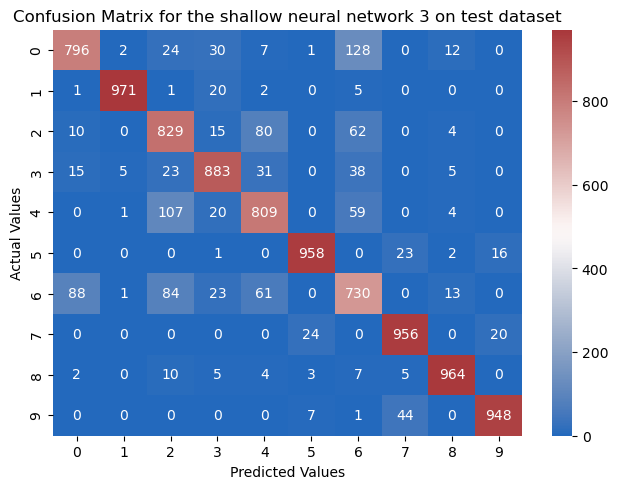

In [74]:
snn3_test_loss, snn3_test_acc = shallow_nn_model3.evaluate(test_images,  test_labels_onehot, verbose=2)

print(f'\nTest accuracy for shallow NN 3: {snn3_test_acc}\n')
print(f"Test loss for shallow NN 3: {snn3_test_loss}\n")

snn3_probability_model = tf.keras.Sequential([shallow_nn_model3, tf.keras.layers.Softmax()])
snn3_prediction_result_softmax= snn3_probability_model.predict(test_images,batch_size= 32)

snn3_test_label_pred = np.argmax(snn3_prediction_result_softmax, axis=1)  # Predicted labels

print(f"first 10 predicted outputs: {snn3_test_label_pred[:10]}\n")
print(f"first 10 true outpurs: {test_labels[:10]}\n")

# Print a classification report for shallow neural network classification model
snn3_classification_report = (classification_report(test_labels, snn3_test_label_pred))
print(snn3_classification_report)

# Print a confusion matrix for shallow neural network on test dataset

snn3_confusion_matrix= (confusion_matrix(test_labels, snn3_test_label_pred))

sns.heatmap(data= snn3_confusion_matrix,fmt='g', annot= True, cmap= "vlag")
plt.title("Confusion Matrix for the shallow neural network 3 on test dataset")
plt.tight_layout()
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.show()

## Basic convolutional neural network (CNN)

### Basic Convolutional Neural Network 1

In [43]:
simple_cnn_model1 = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (28, 28, 1)),
    tf.keras.layers.Conv2D(filters= 32, kernel_size= (3, 3), activation= "relu"),
    tf.keras.layers.MaxPool2D(pool_size= (2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units= 128, activation= "relu"),
    tf.keras.layers.Dense(10)
])

simple_cnn_model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

simple_cnn1_history = simple_cnn_model1.fit(train_images, train_labels_onehot, epochs=100, validation_split= 0.2, batch_size= 32)

Epoch 1/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.8182 - loss: 0.5213 - val_accuracy: 0.8710 - val_loss: 0.3620
Epoch 2/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8838 - loss: 0.3185 - val_accuracy: 0.8754 - val_loss: 0.3691
Epoch 3/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8979 - loss: 0.2759 - val_accuracy: 0.8785 - val_loss: 0.3872
Epoch 4/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9111 - loss: 0.2418 - val_accuracy: 0.8758 - val_loss: 0.4482
Epoch 5/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9164 - loss: 0.2313 - val_accuracy: 0.8748 - val_loss: 0.4616
Epoch 6/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9245 - loss: 0.2048 - val_accuracy: 0.8828 - val_loss: 0.4730
Epoch 7/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9296 - loss: 0.1934 - val_accuracy: 0.8757 - val_loss: 0.5356
Epoch 8/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9360 - loss: 

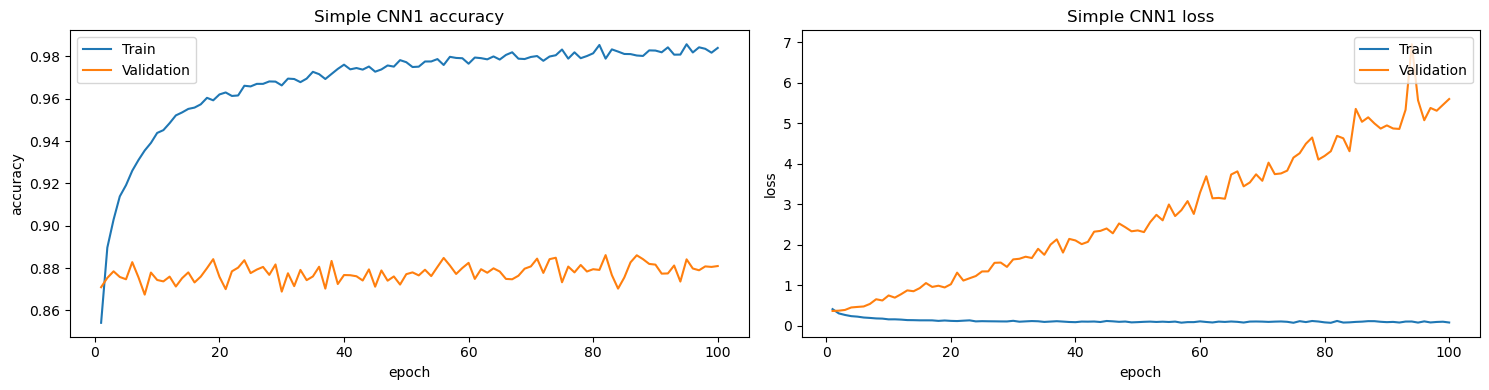

In [75]:
PlotTrainAndValidationAccuracyAndLoss(simple_cnn1_history, "Simple CNN1")

313/313 - 3s - 8ms/step - accuracy: 0.8740 - loss: 6.0133

Test accuracy for Simple CNN 1: 0.8740000128746033

Test loss for Simple CNN 1: 6.013285160064697

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
first 10 predicted outputs: [9 2 1 1 6 1 2 6 5 7]

first 10 true outpurs: [9 2 1 1 6 1 4 6 5 7]

              precision    recall  f1-score   support

           0       0.83      0.80      0.81      1000
           1       0.98      0.97      0.98      1000
           2       0.75      0.78      0.76      1000
           3       0.91      0.88      0.89      1000
           4       0.78      0.75      0.77      1000
           5       0.97      0.97      0.97      1000
           6       0.67      0.70      0.68      1000
           7       0.93      0.97      0.95      1000
           8       0.98      0.97      0.98      1000
           9       0.97      0.93      0.95      1000

    accuracy                           0.87     10000
   macro avg       0.88      0.87      0.87     10000


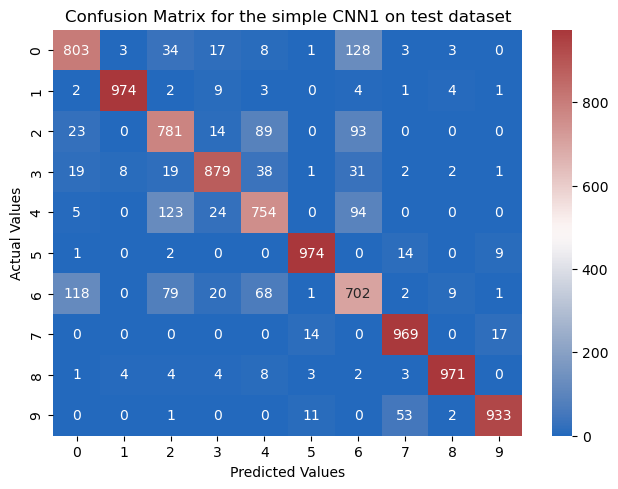

In [76]:
simple_cnn1_test_loss, simple_cnn1_test_acc = simple_cnn_model1.evaluate(test_images,  test_labels_onehot, verbose=2)

print(f'\nTest accuracy for Simple CNN 1: {simple_cnn1_test_acc}\n')
print(f"Test loss for Simple CNN 1: {simple_cnn1_test_loss}\n")

simple_cnn1_probability_model = tf.keras.Sequential([simple_cnn_model1, tf.keras.layers.Softmax()])
simple_cnn1_prediction_result_softmax= simple_cnn1_probability_model.predict(test_images,batch_size= 32)

simple_cnn1_test_label_pred = np.argmax(simple_cnn1_prediction_result_softmax, axis=1)  # Predicted labels

print(f"first 10 predicted outputs: {simple_cnn1_test_label_pred[:10]}\n")
print(f"first 10 true outpurs: {test_labels[:10]}\n")

# Print a classification report for shallow neural network classification model
simple_cnn1_classification_report = (classification_report(test_labels, simple_cnn1_test_label_pred))
print(simple_cnn1_classification_report)

# Print a confusion matrix for simple convolution neural network on test dataset

simple_cnn1_confusion_matrix= (confusion_matrix(test_labels, simple_cnn1_test_label_pred))

sns.heatmap(data= simple_cnn1_confusion_matrix, fmt='g', annot= True, cmap= "vlag")
plt.title("Confusion Matrix for the simple CNN1 on test dataset")
plt.tight_layout()
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.show()

In [44]:
simple_cnn_model2 = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (28, 28, 1)),
    tf.keras.layers.Conv2D(filters= 64, kernel_size= (3, 3), activation= "relu"),
    tf.keras.layers.MaxPool2D(pool_size= (3, 3)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units= 256, activation= "relu"),
    tf.keras.layers.Dense(10)
])

simple_cnn_model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

simple_cnn2_history = simple_cnn_model2.fit(train_images, train_labels_onehot, epochs=100, validation_split= 0.2, batch_size= 64)

Epoch 1/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.7746 - loss: 0.6254 - val_accuracy: 0.8781 - val_loss: 0.3459
Epoch 2/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8831 - loss: 0.3325 - val_accuracy: 0.8911 - val_loss: 0.3051
Epoch 3/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8972 - loss: 0.2842 - val_accuracy: 0.8992 - val_loss: 0.2846
Epoch 4/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9092 - loss: 0.2502 - val_accuracy: 0.9015 - val_loss: 0.2771
Epoch 5/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9185 - loss: 0.2229 - val_accuracy: 0.9046 - val_loss: 0.2715
Epoch 6/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9271 - loss: 0.1984 - val_accuracy: 0.9060 - val_loss: 0.2673
Epoch 7/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9358 - loss: 0.1758 - val_accuracy: 0.9068 - val_loss: 0.2676
Epoch 8/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9440 - loss: 0.1555 - val_accu

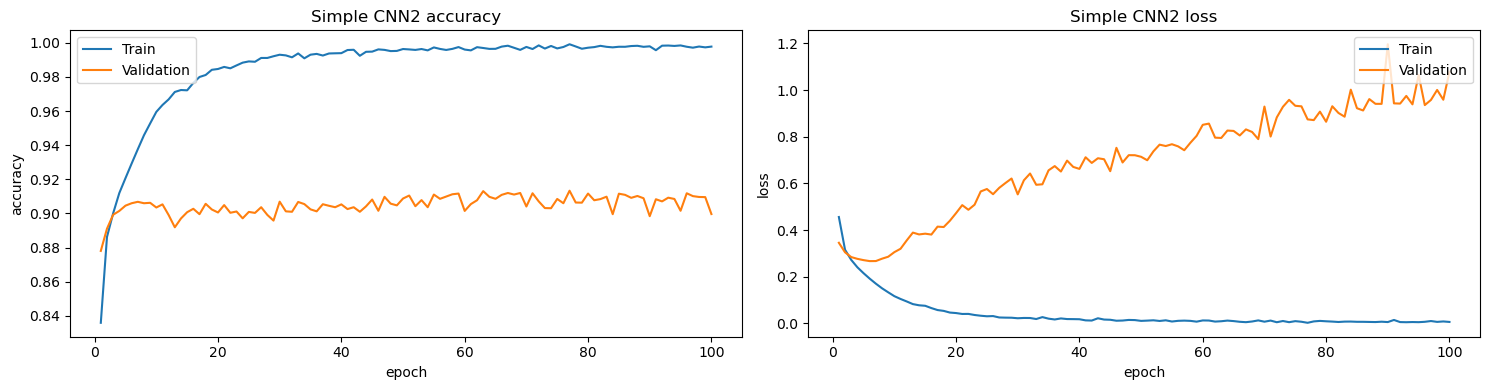

In [77]:
PlotTrainAndValidationAccuracyAndLoss(simple_cnn2_history, "Simple CNN2")

313/313 - 2s - 6ms/step - accuracy: 0.8951 - loss: 1.2195

Test accuracy for Simple CNN 2: 0.8950999975204468

Test loss for Simple CNN 2: 1.2195097208023071

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
first 10 predicted outputs: [9 2 1 1 6 1 4 6 5 7]

first 10 true outpurs: [9 2 1 1 6 1 4 6 5 7]

              precision    recall  f1-score   support

           0       0.84      0.85      0.84      1000
           1       0.99      0.98      0.98      1000
           2       0.84      0.85      0.85      1000
           3       0.93      0.88      0.90      1000
           4       0.76      0.91      0.83      1000
           5       0.93      0.99      0.96      1000
           6       0.77      0.65      0.70      1000
           7       0.96      0.91      0.94      1000
           8       0.99      0.96      0.98      1000
           9       0.96      0.96      0.96      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.89     10000

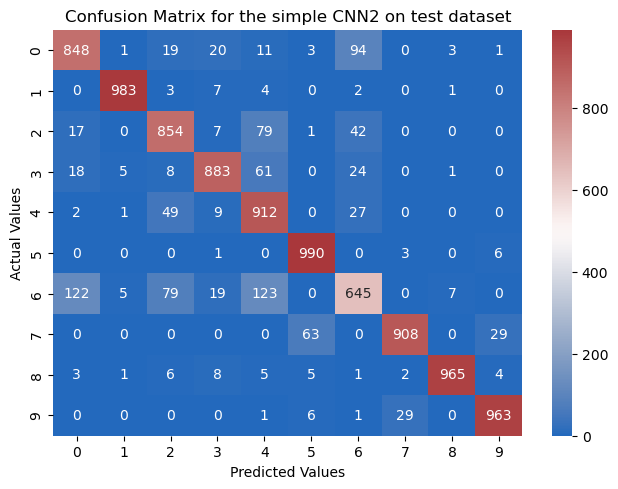

In [78]:
simple_cnn2_test_loss, simple_cnn2_test_acc = simple_cnn_model2.evaluate(test_images,  test_labels_onehot, verbose=2)

print(f'\nTest accuracy for Simple CNN 2: {simple_cnn2_test_acc}\n')
print(f"Test loss for Simple CNN 2: {simple_cnn2_test_loss}\n")

simple_cnn2_probability_model = tf.keras.Sequential([simple_cnn_model2, tf.keras.layers.Softmax()])
simple_cnn2_prediction_result_softmax= simple_cnn2_probability_model.predict(test_images,batch_size= 32)

simple_cnn2_test_label_pred = np.argmax(simple_cnn2_prediction_result_softmax, axis=1)  # Predicted labels

print(f"first 10 predicted outputs: {simple_cnn2_test_label_pred[:10]}\n")
print(f"first 10 true outpurs: {test_labels[:10]}\n")

# Print a classification report for shallow neural network classification model
simple_cnn2_classification_report = (classification_report(test_labels, simple_cnn2_test_label_pred))
print(simple_cnn2_classification_report)

# Print a confusion matrix for simple convolution neural network on test dataset

simple_cnn2_confusion_matrix= (confusion_matrix(test_labels, simple_cnn2_test_label_pred))

sns.heatmap(data= simple_cnn2_confusion_matrix, fmt='g', annot= True, cmap= "vlag")
plt.title("Confusion Matrix for the simple CNN2 on test dataset")
plt.tight_layout()
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.show()

In [45]:
simple_cnn_model3 = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (28, 28, 1)),
    tf.keras.layers.Conv2D(filters= 32, kernel_size= (3, 3), activation= "relu"),
    tf.keras.layers.MaxPool2D(pool_size= (2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units= 256, activation= "tanh"),
    tf.keras.layers.Dense(10)
])

simple_cnn_model3.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.005),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

simple_cnn3_history = simple_cnn_model3.fit(train_images, train_labels_onehot, epochs=100, validation_split= 0.2, batch_size= 64)

Epoch 1/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.5555 - loss: 1.3827 - val_accuracy: 0.7785 - val_loss: 0.6463
Epoch 2/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.7831 - loss: 0.6244 - val_accuracy: 0.8037 - val_loss: 0.5541
Epoch 3/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8047 - loss: 0.5455 - val_accuracy: 0.8154 - val_loss: 0.5155
Epoch 4/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8170 - loss: 0.5073 - val_accuracy: 0.8246 - val_loss: 0.4922
Epoch 5/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8265 - loss: 0.4832 - val_accuracy: 0.8296 - val_loss: 0.4757
Epoch 6/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8332 - loss: 0.4651 - val_accuracy: 0.8348 - val_loss: 0.4625
Epoch 7/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8393 - loss: 0.4506 - val_accuracy: 0.8389 - val_loss: 0.4516
Epoch 8/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8436 - loss: 0.4386 - val_accu

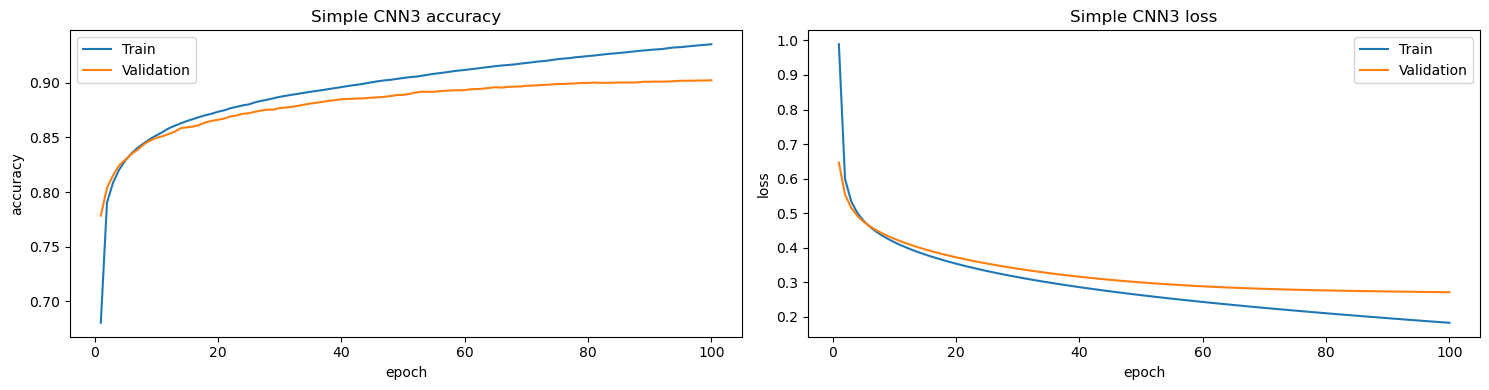

In [48]:
PlotTrainAndValidationAccuracyAndLoss(simple_cnn3_history, "Simple CNN3")

313/313 - 1s - 3ms/step - accuracy: 0.8958 - loss: 0.2872

Test accuracy for Simple CNN 3: 0.895799994468689

Test loss for Simple CNN 3: 0.2872489094734192

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
first 10 predicted outputs: [9 2 1 1 6 1 4 6 5 7]

first 10 true outpurs: [9 2 1 1 6 1 4 6 5 7]

              precision    recall  f1-score   support

           0       0.89      0.80      0.84      1000
           1       0.99      0.97      0.98      1000
           2       0.80      0.86      0.83      1000
           3       0.89      0.91      0.90      1000
           4       0.88      0.77      0.82      1000
           5       0.98      0.97      0.97      1000
           6       0.69      0.78      0.73      1000
           7       0.93      0.97      0.95      1000
           8       0.97      0.97      0.97      1000
           9       0.97      0.95      0.96      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000


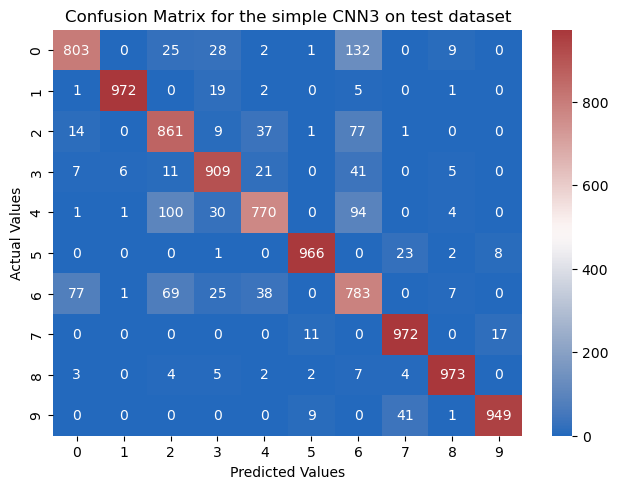

In [79]:
simple_cnn3_test_loss, simple_cnn3_test_acc = simple_cnn_model3.evaluate(test_images,  test_labels_onehot, verbose=2)

print(f'\nTest accuracy for Simple CNN 3: {simple_cnn3_test_acc}\n')
print(f"Test loss for Simple CNN 3: {simple_cnn3_test_loss}\n")

simple_cnn3_probability_model = tf.keras.Sequential([simple_cnn_model3, tf.keras.layers.Softmax()])
simple_cnn3_prediction_result_softmax= simple_cnn3_probability_model.predict(test_images,batch_size= 32)

simple_cnn3_test_label_pred = np.argmax(simple_cnn3_prediction_result_softmax, axis=1)  # Predicted labels

print(f"first 10 predicted outputs: {simple_cnn3_test_label_pred[:10]}\n")
print(f"first 10 true outpurs: {test_labels[:10]}\n")

# Print a classification report for shallow neural network classification model
simple_cnn3_classification_report = (classification_report(test_labels, simple_cnn3_test_label_pred))
print(simple_cnn3_classification_report)

# Print a confusion matrix for simple convolution neural network on test dataset

simple_cnn3_confusion_matrix= (confusion_matrix(test_labels, simple_cnn3_test_label_pred))

sns.heatmap(data= simple_cnn3_confusion_matrix, fmt='g', annot= True, cmap= "vlag")
plt.title("Confusion Matrix for the simple CNN3 on test dataset")
plt.tight_layout()
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.show()

## Deep Convolution Neural Network

### Deep CNN 1

In [53]:
deep_cnn_model1 = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (28, 28, 1)),
    tf.keras.layers.Conv2D(filters= 32, kernel_size= (3, 3), activation= "relu"),
    tf.keras.layers.MaxPool2D(pool_size= (2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units= 256, activation= "tanh"),
    tf.keras.layers.Dense(10, activation='softmax')
])

deep_cnn_model1.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.005),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

deep_cnn1_history = deep_cnn_model1.fit(train_images, train_labels_onehot, epochs=100, validation_split= 0.2, batch_size= 64)

Epoch 1/100


/home/buddha-thapa-magar/anaconda3/envs/ml/lib/python3.12/site-packages/keras/src/backend/tensorflow/nn.py:593: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.3933 - loss: 1.8964 - val_accuracy: 0.7249 - val_loss: 0.8064
Epoch 2/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7194 - loss: 0.7755 - val_accuracy: 0.7620 - val_loss: 0.6625
Epoch 3/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7553 - loss: 0.6601 - val_accuracy: 0.7802 - val_loss: 0.5980
Epoch 4/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7767 - loss: 0.5987 - val_accuracy: 0.7923 - val_loss: 0.5552
Epoch 5/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7926 - loss: 0.5557 - val_accuracy: 0.8038 - val_loss: 0.5252
Epoch 6/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8050 - loss: 0.5242 - val_accuracy: 0.8138 - val_loss: 0.5026
Epoch 7/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8148 - loss: 0.4998 - val_accuracy: 0.8211 - val_loss: 0.4846
Epoch 8/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8230 - loss: 0.4801 - val_accuracy: 0.8262

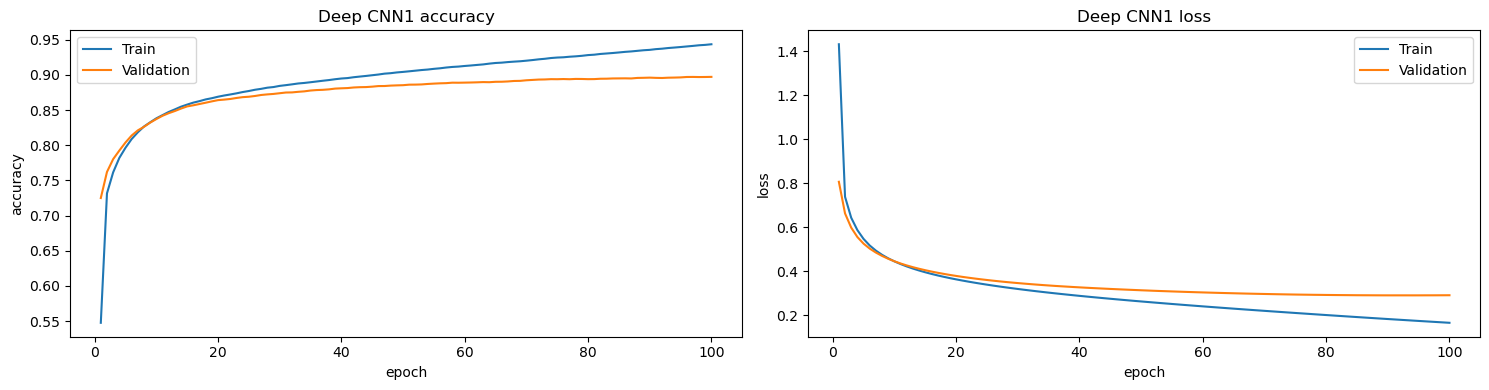

In [80]:
PlotTrainAndValidationAccuracyAndLoss(deep_cnn1_history, "Deep CNN1")

313/313 - 1s - 4ms/step - accuracy: 0.8958 - loss: 0.2940

Test accuracy for Deep CNN 1: 0.895799994468689

Test loss for Deep CNN 1: 0.2939700186252594

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
first 10 predicted outputs: [9 2 1 1 6 1 4 6 5 7]

first 10 true outpurs: [9 2 1 1 6 1 4 6 5 7]

              precision    recall  f1-score   support

           0       0.87      0.81      0.84      1000
           1       0.99      0.98      0.98      1000
           2       0.79      0.87      0.83      1000
           3       0.90      0.92      0.91      1000
           4       0.84      0.80      0.82      1000
           5       0.98      0.97      0.97      1000
           6       0.72      0.71      0.71      1000
           7       0.95      0.97      0.96      1000
           8       0.96      0.97      0.97      1000
           9       0.97      0.96      0.97      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weig

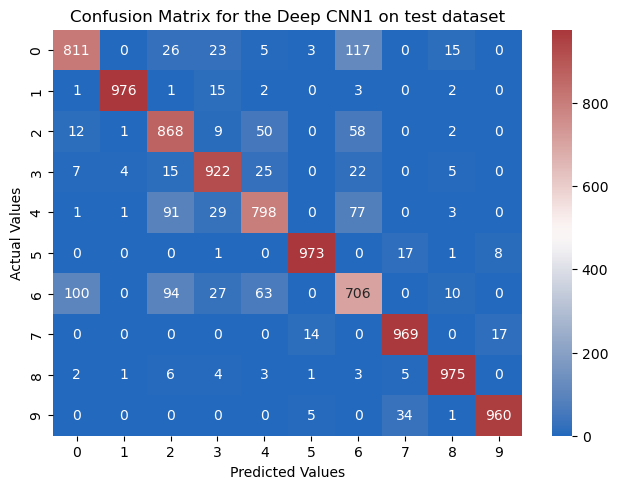

In [81]:
deep_cnn1_test_loss, deep_cnn1_test_acc = deep_cnn_model1.evaluate(test_images,  test_labels_onehot, verbose=2)

print(f'\nTest accuracy for Deep CNN 1: {deep_cnn1_test_acc}\n')
print(f"Test loss for Deep CNN 1: {deep_cnn1_test_loss}\n")

deep_cnn1_probability_model = tf.keras.Sequential([deep_cnn_model1, tf.keras.layers.Softmax()])
deep_cnn1_prediction_result_softmax= deep_cnn1_probability_model.predict(test_images,batch_size= 32)

deep_cnn1_test_label_pred = np.argmax(deep_cnn1_prediction_result_softmax, axis=1)  # Predicted labels

print(f"first 10 predicted outputs: {deep_cnn1_test_label_pred[:10]}\n")
print(f"first 10 true outpurs: {test_labels[:10]}\n")

# Print a classification report for Deep convolution neural network classification model
deep_cnn1_classification_report = (classification_report(test_labels, deep_cnn1_test_label_pred))
print(deep_cnn1_classification_report)

# Print a confusion matrix for deep convolution neural network on test dataset

deep_cnn1_confusion_matrix= (confusion_matrix(test_labels, deep_cnn1_test_label_pred))

sns.heatmap(data= deep_cnn1_confusion_matrix, fmt='g', annot= True, cmap= "vlag")
plt.title("Confusion Matrix for the Deep CNN1 on test dataset")
plt.tight_layout()
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.show()

In [54]:
deep_cnn_model2 = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (28, 28, 1)),
    tf.keras.layers.Conv2D(filters= 32, kernel_size= (3, 3), activation= "relu"),
    tf.keras.layers.MaxPool2D(pool_size= (2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units= 256, activation= "tanh"),
    tf.keras.layers.Dense(10, activation='softmax')
])

deep_cnn_model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

deep_cnn2_history = deep_cnn_model2.fit(train_images, train_labels_onehot, epochs=100, validation_split= 0.2, batch_size= 64)

Epoch 1/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.6818 - loss: 0.8581 - val_accuracy: 0.8419 - val_loss: 0.4321
Epoch 2/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8438 - loss: 0.4257 - val_accuracy: 0.8652 - val_loss: 0.3647
Epoch 3/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.8690 - loss: 0.3584 - val_accuracy: 0.8762 - val_loss: 0.3397
Epoch 4/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8820 - loss: 0.3187 - val_accuracy: 0.8846 - val_loss: 0.3231
Epoch 5/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8931 - loss: 0.2856 - val_accuracy: 0.8879 - val_loss: 0.3117
Epoch 6/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9056 - loss: 0.2600 - val_accuracy: 0.8895 - val_loss: 0.3104
Epoch 7/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9138 - loss: 0.2365 - val_accuracy: 0.8922 - val_loss: 0.3092
Epoch 8/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9209 - loss: 0.2136 - val_acc

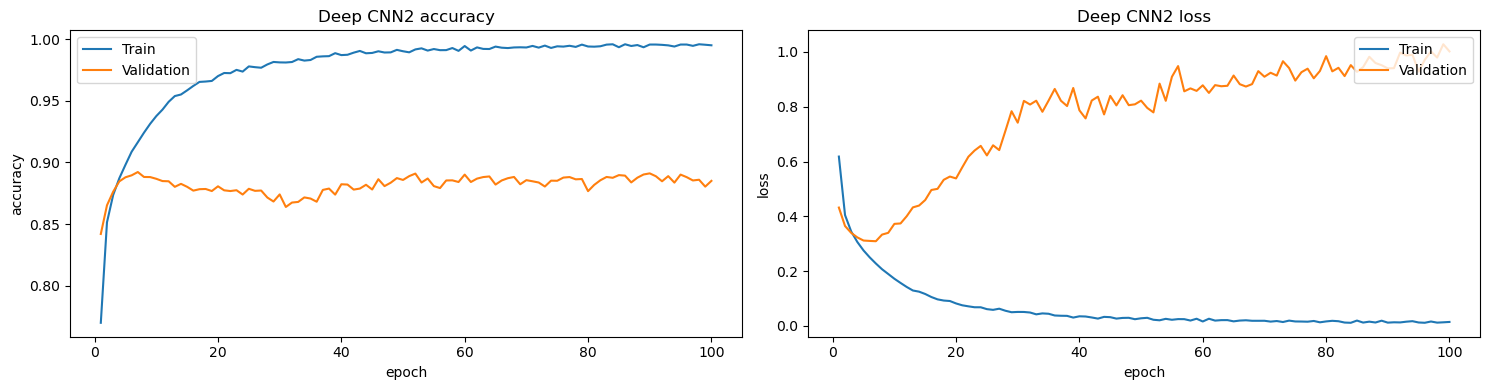

In [82]:
PlotTrainAndValidationAccuracyAndLoss(deep_cnn2_history, "Deep CNN2")

313/313 - 2s - 7ms/step - accuracy: 0.8797 - loss: 1.0999

Test accuracy for Deep CNN 2: 0.8797000050544739

Test loss for Deep CNN 2: 1.099922776222229

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
first 10 predicted outputs: [9 2 1 1 4 1 4 6 5 7]

first 10 true outpurs: [9 2 1 1 6 1 4 6 5 7]

              precision    recall  f1-score   support

           0       0.82      0.82      0.82      1000
           1       0.99      0.97      0.98      1000
           2       0.82      0.81      0.81      1000
           3       0.91      0.86      0.88      1000
           4       0.78      0.85      0.81      1000
           5       0.96      0.97      0.97      1000
           6       0.67      0.68      0.67      1000
           7       0.94      0.95      0.94      1000
           8       0.96      0.96      0.96      1000
           9       0.96      0.93      0.95      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weig

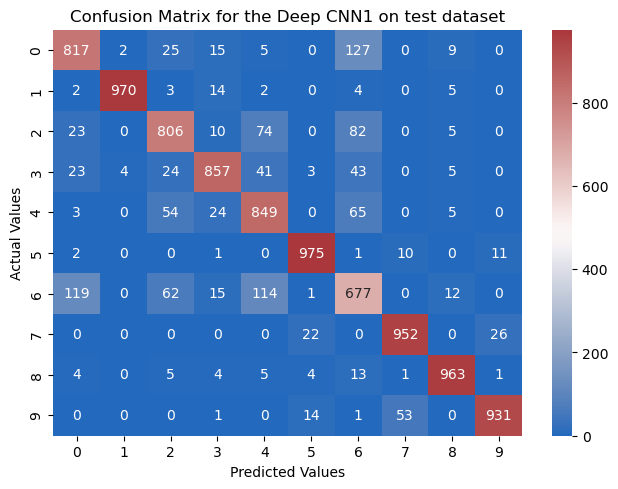

In [83]:
deep_cnn2_test_loss, deep_cnn2_test_acc = deep_cnn_model2.evaluate(test_images,  test_labels_onehot, verbose=2)

print(f'\nTest accuracy for Deep CNN 2: {deep_cnn2_test_acc}\n')
print(f"Test loss for Deep CNN 2: {deep_cnn2_test_loss}\n")

deep_cnn2_probability_model = tf.keras.Sequential([deep_cnn_model2, tf.keras.layers.Softmax()])
deep_cnn2_prediction_result_softmax= deep_cnn2_probability_model.predict(test_images,batch_size= 32)

deep_cnn2_test_label_pred = np.argmax(deep_cnn2_prediction_result_softmax, axis=1)  # Predicted labels

print(f"first 10 predicted outputs: {deep_cnn2_test_label_pred[:10]}\n")
print(f"first 10 true outpurs: {test_labels[:10]}\n")

# Print a classification report for Deep convolution neural network classification model
deep_cnn2_classification_report = (classification_report(test_labels, deep_cnn2_test_label_pred))
print(deep_cnn2_classification_report)

# Print a confusion matrix for deep convolution neural network on test dataset

deep_cnn2_confusion_matrix= (confusion_matrix(test_labels, deep_cnn2_test_label_pred))

sns.heatmap(data= deep_cnn2_confusion_matrix, fmt='g', annot= True, cmap= "vlag")
plt.title("Confusion Matrix for the Deep CNN1 on test dataset")
plt.tight_layout()
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.show()

In [55]:
deep_cnn_model3 = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (28, 28, 1)),
    tf.keras.layers.Conv2D(filters= 32, kernel_size= (3, 3), activation= "relu"),
    tf.keras.layers.MaxPool2D(pool_size= (2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units= 256, activation= "tanh"),
    tf.keras.layers.Dense(10, activation='softmax')
])

deep_cnn_model3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

deep_cnn3_history = deep_cnn_model3.fit(train_images, train_labels_onehot, epochs=100, validation_split= 0.2, batch_size= 64)

Epoch 1/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.7648 - loss: 0.6305 - val_accuracy: 0.8765 - val_loss: 0.3418
Epoch 2/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8819 - loss: 0.3295 - val_accuracy: 0.8915 - val_loss: 0.2965
Epoch 3/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9000 - loss: 0.2767 - val_accuracy: 0.8997 - val_loss: 0.2785
Epoch 4/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9138 - loss: 0.2391 - val_accuracy: 0.9049 - val_loss: 0.2701
Epoch 5/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9253 - loss: 0.2072 - val_accuracy: 0.9059 - val_loss: 0.2713
Epoch 6/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9344 - loss: 0.1805 - val_accuracy: 0.9068 - val_loss: 0.2726
Epoch 7/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9448 - loss: 0.1540 - val_accuracy: 0.9045 - val_loss: 0.2977
Epoch 8/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9533 - loss: 0.1307 - val_accu

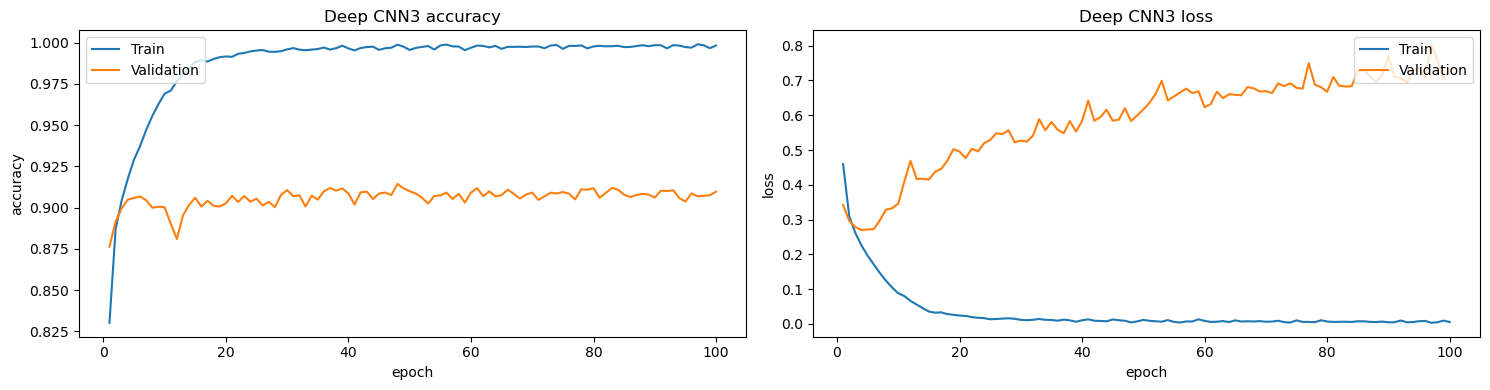

In [58]:
PlotTrainAndValidationAccuracyAndLoss(deep_cnn3_history, "Deep CNN3")

313/313 - 2s - 6ms/step - accuracy: 0.9029 - loss: 0.8389

Test accuracy for Deep CNN 3: 0.902899980545044

Test loss for Deep CNN 3: 0.8389164805412292

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step
first 10 predicted outputs: [9 2 1 1 6 1 2 6 5 7]

first 10 true outpurs: [9 2 1 1 6 1 4 6 5 7]

              precision    recall  f1-score   support

           0       0.86      0.85      0.86      1000
           1       1.00      0.98      0.99      1000
           2       0.82      0.86      0.84      1000
           3       0.91      0.91      0.91      1000
           4       0.84      0.85      0.85      1000
           5       0.98      0.97      0.97      1000
           6       0.73      0.71      0.72      1000
           7       0.94      0.97      0.96      1000
           8       0.98      0.97      0.97      1000
           9       0.97      0.96      0.96      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weig

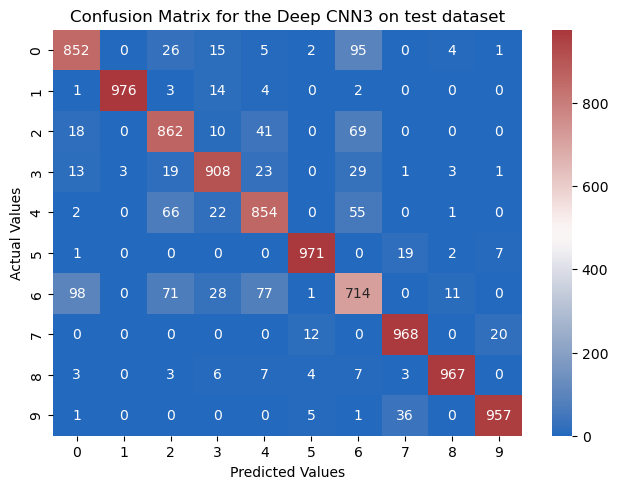

In [84]:
deep_cnn3_test_loss, deep_cnn3_test_acc = deep_cnn_model3.evaluate(test_images,  test_labels_onehot, verbose=2)

print(f'\nTest accuracy for Deep CNN 3: {deep_cnn3_test_acc}\n')
print(f"Test loss for Deep CNN 3: {deep_cnn3_test_loss}\n")

deep_cnn3_probability_model = tf.keras.Sequential([deep_cnn_model3, tf.keras.layers.Softmax()])
deep_cnn3_prediction_result_softmax= deep_cnn3_probability_model.predict(test_images,batch_size= 32)

deep_cnn3_test_label_pred = np.argmax(deep_cnn3_prediction_result_softmax, axis=1)  # Predicted labels

print(f"first 10 predicted outputs: {deep_cnn3_test_label_pred[:10]}\n")
print(f"first 10 true outpurs: {test_labels[:10]}\n")

# Print a classification report for Deep convolution neural network classification model
deep_cnn3_classification_report = (classification_report(test_labels, deep_cnn3_test_label_pred))
print(deep_cnn3_classification_report)

# Print a confusion matrix for deep convolution neural network on test dataset

deep_cnn3_confusion_matrix= (confusion_matrix(test_labels, deep_cnn3_test_label_pred))

sns.heatmap(data= deep_cnn3_confusion_matrix, fmt='g', annot= True, cmap= "vlag")
plt.title("Confusion Matrix for the Deep CNN3 on test dataset")
plt.tight_layout()
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.show()